# Sample Code

## 基礎建設

In [2]:
import pandas as pd
import gzip, json

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

## 載入資料

In [3]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz

--2021-12-26 13:15:21--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15499476 (15M) [application/octet-stream]
Saving to: ‘All_Beauty.csv’

All_Beauty.csv      100%[===================>]  14.78M  17.9MB/s    in 0.8s    

2021-12-26 13:15:22 (17.9 MB/s) - ‘All_Beauty.csv’ saved [15499476/15499476]

--2021-12-26 13:15:22--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10329961 (9.9M) [application/octet-stream]
Saving to: ‘meta_All_Beauty.json.gz’

meta_All_Beauty.jso 100%[===================>]   9.85M  14.1MB/s    in 0.7s    

202

In [4]:
metadata = getDF('/content/meta_All_Beauty.json.gz')
ratings = pd.read_csv('/content/All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

In [5]:
metadata.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]
3,[],,[],,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,,[],"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",All Beauty,,,,7367905066,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,[],,[Lacto Calamine Skin Balance Daily Nourishing ...,,Lacto Calamine Skin Balance Oil control 120 ml...,[],,Pirmal Healthcare,[],"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,7414204790,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [6]:
ratings.head()

,asin,reviewerID,overall,unixReviewTime
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800
2,0143026860,A1572GUYS7DGSR,4.0,1407628800
3,0143026860,A1PSGLFK1NSVO,5.0,1362960000
4,0143026860,A6IKXKZMTKGSC,5.0,1324771200


## 資料整理

In [7]:
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')

## 資料切分

In [72]:
ratings_trainings = ratings[
    (ratings['DATE'] < '2018-09-01')
]
ratings_testings = ratings[
    (ratings['DATE'] >= '2018-09-01') & 
    (ratings['DATE'] <= '2018-09-30')
]
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
users = list(ratings_testings_by_user.keys())

## 檢視數據趨勢

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8c7686b10>,
      dtype=object)

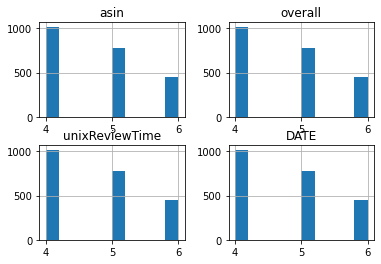

In [49]:
ratings_trainings.groupby('reviewerID').count().sort_values('asin').hist(bins=10,range=(4,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8c80589d0>,
      dtype=object)

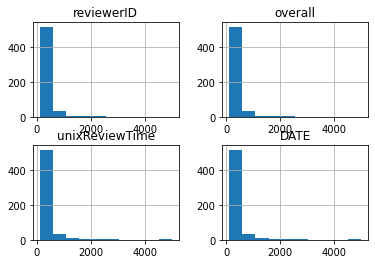

In [43]:
ratings_trainings.groupby('asin').count().sort_values('reviewerID').hist(bins=10,range=(100,5000))

## TMP

In [54]:

ratings_trainings.groupby('reviewerID').agg(list)['asin'].rename('asin_list')

reviewerID
A0010876CNE3ILIM9HV0                            [B01FHDYGQ8]
A001170867ZBE9FORRQL                [B01B18T01Y, B01FCW88D6]
A0028738FYF1SKPPC7B1                            [B00TZ8XK1E]
A0045356A23634W7RI4M                            [B018H0EJI8]
A006277084SDH2LTUV6X                            [B01DKQAXC0]
                                        ...                 
AZZW8CF93X1TC                                   [B01HD23OJG]
AZZWNU4RB5BY1                                   [B01E5GSQOQ]
AZZXKG9AGRVGU                                   [B01DVW54I6]
AZZYW4YOE1B6E                                   [B003KWO3UI]
AZZZ5UJWUVCYZ           [B00IIZG80U, B01FNJ9MOW, B01CZC20DU]
Name: asin_list, Length: 323489, dtype: object

In [77]:
pp = ratings_trainings.join(ratings_trainings.groupby('reviewerID').agg(list)['asin'].rename('asin_list'),on='reviewerID')

In [83]:
recom_p_to_p = pp.groupby('asin').agg(list).reset_index()[['asin','asin_list']].to_dict('records')

In [85]:
recom_p_to_p = {r['asin']: flatmatrix(r['asin_list']) for r in recom_p_to_p}

In [84]:
def flatmatrix(matrix):
    result = []
    for i in range(len(matrix)):
        result.extend(matrix[i])
    return list(set(result))


In [147]:
ratings_trainings.loc[76840,'asin']

'B001F51RAG'

In [149]:
recom_p_to_p[ratings_trainings.loc[76840,'asin']][:10]

['B001F51R9M',
 'B008YQM4A6',
 'B00P9QIHG4',
 'B00P1IHA68',
 'B00QYJ84GI',
 'B01AQYVEC2',
 'B00763F252',
 'B001ECVFFC',
 'B013J5W6ZE',
 'B000LCETUO']

## 產生推薦

In [159]:
def recommender_1(training_data, users=[], k=10):
    '''
    * training_data: dataframe 輸入的訓練資料集（2018-09-01 以前資料）
    * users: [] 需要被推薦的使用者
    * k: int 每個使用者需要推薦的商品數
    * recommendations: dict
      {
          使用者一： [推薦商品一, 推薦商品二, ...],
          使用者二： [...], ...
      }
    '''
    recommendations = {}

    rcom = ratings_trainings.groupby('asin').count().sort_values('overall',ascending=False).head(k).index.tolist()

    recommendations = {u: rcom for u in users}

    return recommendations


ratings_by_user = recommender_1(ratings_trainings, users)
#ratings_by_user

In [154]:
def flatmatrix(matrix):
    result = []
    for i in range(len(matrix)):
        result.extend(matrix[i])
    return list(set(result))
def recommender_2(training_data, users=[], k=10):
    '''
    * training_data: dataframe 輸入的訓練資料集（2018-09-01 以前資料）
    * users: [] 需要被推薦的使用者
    * k: int 每個使用者需要推薦的商品數
    * recommendations: dict
      {
          使用者一： [推薦商品一, 推薦商品二, ...],
          使用者二： [...], ...
      }
    '''
    recommendations = {}

    pp = ratings_trainings.join(ratings_trainings.groupby('reviewerID').agg(list)['asin'].rename('asin_list'),on='reviewerID')
    recom_p_to_p = pp.groupby('asin').agg(list).reset_index()[['asin','asin_list']].to_dict('records')
    recom_p_to_p = {r['asin']: flatmatrix(r['asin_list']) for r in recom_p_to_p}
    
    
    recommendations = {}

    for u in users:
        try:
            idx_ = ratings_trainings.loc[ratings_trainings.reviewerID == u,'overall'].idxmax()
            recommendations[u] = recom_p_to_p[ratings_trainings.loc[idx_,'asin']][:10]
        except:
            print(u)


    return recommendations


ratings_by_user = recommender_2(ratings_trainings, users)
ratings_by_user

A100XQFWKQ30O2
A103T1QOGFCSEH
A106UKKSJ2KXPF
A10A7GV4D5A11V
A1119JJ37ZLB8R
A113UOOLBSZN52
A12M4U7WK4ALCR
A12T8YTW6VWT7S
A1364JXGKB46MM
A137DALOQFKBTI
A13FEZ3WV7S2EY
A13IV4I1B0RXMG
A13K55R6VH1OOD
A13P7VFU075A
A13SWYE4QLB6NG
A13ZTQ0Q4ATA41
A142EDN04OD62U
A142I22FIC8MZK
A14834QTII5TLT
A14A447VPACTBC
A14AP6MN5XO6LB
A14CLF25IX25US
A14LYXC3HTBAHI
A14VUW4KZ34EOE
A14Y32P26G9YL
A157T25PBS7MX4
A15HZDSERD85C8
A15JJ8J1FGADIX
A15ZCL70JXXH89
A1617KN2IAWZ6J
A16E0O88262HKA
A16NSZ58PTVIYF
A16UGDXRTDLJG5
A16X9HR3UFQQXY
A174YOBOSW9WDN
A1786SKRAJXH86
A17K2BUZ20WD2
A17LYRFV645L0V
A18LNGVXDZBTUR
A19HVHRZDYFEOP
A19JM38B861BO4
A19KGY3W1P0MHT
A19KJPOF3QOJ24
A19U5RT4Q8Q1T6
A1AQNQUNX8B6JT
A1ARU0IN6RUFFD
A1BB4635KSKDMV
A1BCC7X6KRTBG0
A1BPJ56BXENC7
A1C0RI6W65FC8B
A1C60LJGZVEK27
A1CB2SMS3TD44Z
A1CNSU8P68CPLT
A1CSDWBYUJBCJZ
A1CTNNVIYHO25P
A1CTQF97HFYOZB
A1D5C2H9UFZHPU
A1D5UVH72Z6NJ1
A1DAUVZRVSLLNW
A1DCZ9882PXLVB
A1DZ63D35BNT86
A1E0QCKB4R2X8X
A1E76OZZ5YUWVA
A1EBHZPAYMILW9
A1EJVNGBY5GM5I
A1ER0356V2DSKW
A1EZFX1TRHSAJX


{'A13JU88JAHN72I': ['B00BWIT33Y', 'B009YDVB6Q'],
 'A16Y7V1CZCWKFV': ['B01DKI8S1Q',
  'B000FVHRXC',
  'B01BEWYRJ2',
  'B01E0T6BPE',
  'B015ZOWER2',
  'B00LSS8IIE',
  'B007SA3AUW',
  'B00WMP9V5G',
  'B01CRWLLX8',
  'B004E4GHRS'],
 'A19503XX7GU6J2': ['B019Z9L2SK',
  'B00OLMCLLE',
  'B01A8GM12A',
  'B000R8V1VM',
  'B0054H0NZ6',
  'B01237XG2Q',
  'B007YT34TY',
  'B019Z9LAPK',
  'B00TJO6GOC',
  'B012Z7IHHI'],
 'A1EY751AUVO5NZ': ['B01F6ENUK6',
  'B00AJECD2A',
  'B01ENDFXJW',
  'B01C74U1UU',
  'B01254XUXW',
  'B001T8UGAG'],
 'A1PR178735XC70': ['B00NNLURMY',
  'B00NM5A4A6',
  'B00RYGTT2S',
  'B00S4ABX2W',
  'B0067F28ZW',
  'B00O1FYJPW',
  'B00NNLYTFU',
  'B00NNLZ5OY',
  'B00PXDQC1A'],
 'A1SA3N793WT2LM': ['B00EE348MU',
  'B00K6Q0PCG',
  'B00KIZ3JS2',
  'B0007QKY80',
  'B005GMYPX0',
  'B000142ZFS',
  'B00LIESAE0',
  'B00NPJVLYW',
  'B019Z9L8PW',
  'B00VBJVGP2'],
 'A1TP9JHTIY468V': ['B00EK248XO',
  'B004LUQRJI',
  'B006LTTBMW',
  'B00MGK9Z8U',
  'B019R7KEPC',
  'B019DWCJDG',
  'B01HBSH2EK',
  'B01

## 結果評估

In [160]:
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / len(ratings_testings)
    return score

evaluate(ratings_testings_by_user, ratings_by_user)

0.08305084745762711

In [158]:
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / len(ratings_testings)
    return score

evaluate(ratings_testings_by_user, ratings_by_user)